# Download CamVid Dataset

Code in below cell downloads subset of CamVid dataset with 12 classes. Run the cell and download the data. Class names(12 in number) and 12 distinct RGB values for different colours is also given.

- Print total number of train, val and test images available in dataset
- Visualize any random image and corrosponding mask with the use of CLASS_NAMES and CLASS_COLORS
- All the images are of same size. Print size of image.

#### Defining the path to the data and the class names and colors

In [1]:
import os

DATA_DIR = './data/CamVid/'

if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')
    
CLASS_NAMES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']

CLASS_COLORS = [(128, 128, 128), (128, 0, 0), (192, 192, 128), (128, 64, 128), (0, 0, 192),
                (128, 128, 0), (192, 128, 128), (64, 64, 128), (64, 0, 128),
                (64, 64, 0), (0, 128, 192), (0, 0, 0)]

Loading data...
Done!


#### Displaying a random image and image size, with corresponding mask

image size =  (480, 360)


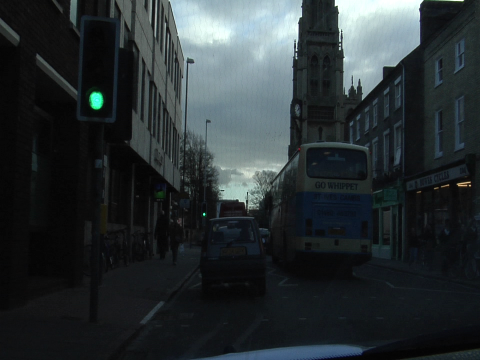

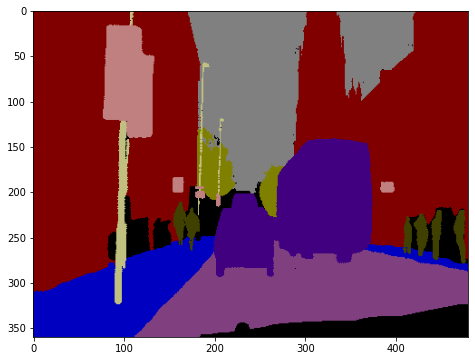

In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

cmap = np.array([[128, 128, 128], [128, 0, 0], [192, 192, 128], [128, 64, 128], [0, 0, 192],
                [128, 128, 0], [192, 128, 128], [64, 64, 128], [64, 0, 128],
                [64, 64, 0], [0, 128, 192], [0, 0, 0]])                 #colour map array

img = Image.open('data/CamVid/train/0001TP_006750.png')
print('image size = ',img.size)
display(img)

mask = tf.io.read_file('data/CamVid/trainannot/0001TP_006750.png')
mask = tf.image.decode_png(mask, channels=3)  #load mask with 3 channels
tmp_label=np.array(mask)  #temp mask    
m2=np.zeros(mask.shape)  #output image initialization

for i in range(12):        #iteration over all classes
  m2+=(tmp_label==i)*cmap[i,:]  #mask label to 3 channel colour

m2=m2.astype(np.uint8)
fig = plt.figure(figsize=(8,6))
plt.imshow(m2)

# DataLoader
We are going to use code shared in [this](https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/) blog post. In the blog, implementation of UNet for ADE20K dataset is given. 
- Using code in this blog, implement dataloader for CamVid dataset. Read tensorflow documentation for better understanding. (Do not resize images in dataset.)
- Vizualize the data sample outputted by implemented dataloader for sanity check of your dataloader implentation. (Code is given in blog)

In [3]:
from glob import glob

import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import tensorflow_addons as tfa

Using TensorFlow backend.


#### Defining the path to the data and displaying number of samples

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

SEED = 2020

#Defining the path to the images
dataset_path = "data/CamVid/"
training_data = "train/"
val_data = "val/"

#Image size that we are going to use
IMG_HEIGHT = 160    
IMG_WIDTH = 224

#Images are RGB (3 channels) and under 12 classes
N_CHANNELS = 3
N_CLASSES = 12

Tensorflow ver. 2.2.0


In [5]:
#Size of the dataset
TRAINSET_SIZE = len(glob(dataset_path + training_data + "*.png"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(dataset_path + val_data + "*.png"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 367 images.
The Validation Dataset contains 101 images.


#### Defining a custom function to parse images in the dataset
#### Applying transformations to the dataset using tf.function wrapper

In [6]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    
    #Defining image and corresponding annotation path
    mask_path = tf.strings.regex_replace(img_path, "train", "trainannot") #change the path for annotation dir
    mask_path = tf.strings.regex_replace(mask_path, "val", "valannot")
    mask = tf.io.read_file(mask_path)

    # The masks contain a class index for each pixel
    mask = tf.image.decode_png(mask, channels=1)

    #In the parsing, 255 means the 255th class, which doesn't exist in our data
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    
    return {'image': image, 'segmentation_mask': mask}


#Making the train and validation dataset from images directories
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.png", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.png", seed=SEED)
val_dataset =val_dataset.map(parse_image)

@tf.function
def normalize(input_image, input_mask):       #rescaling pixel values in range of 0,1   
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image, input_mask

@tf.function
def load_image_train(datapoint): #Reshape images to maintain consistancy during upsampling and downsampling
    #Note: The same transformation(augmentation) has to be added to image as well as its annotation

  input_image = tf.image.resize(datapoint['image'], (IMG_HEIGHT, IMG_WIDTH ))              
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_HEIGHT, IMG_WIDTH))
  #Random horizontal flips
  if tf.random.uniform(()) > 0.5:        
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):  #No augmentation needed for test data, so we only normalize and resize the image and its annotation
  input_image = tf.image.resize(datapoint['image'], (IMG_HEIGHT, IMG_WIDTH))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_HEIGHT, IMG_WIDTH))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

BATCH_SIZE = 8

# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset}

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['val'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

print(train_dataset)
print(test_dataset)

<PrefetchDataset shapes: ((None, 160, 224, 3), (None, 160, 224, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 160, 224, 3), (None, 160, 224, 1)), types: (tf.float32, tf.float32)>


#### Color mask and visualizing the dataset

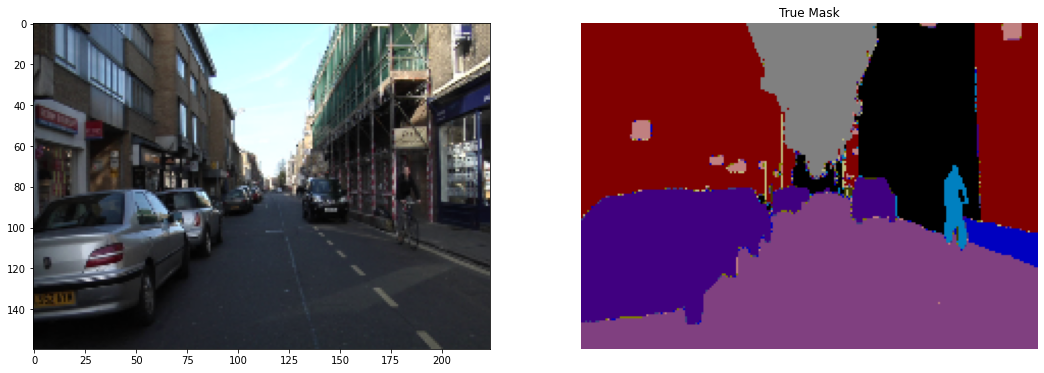

In [7]:
def color_code(m_image):
  mask = tf.image.grayscale_to_rgb(m_image)  #3channel mask
  mask = np.round_(np.array(mask))  #temp mask    
  m2=np.zeros(mask.shape)  #output image initialization
  for i in range(N_CLASSES): #iteration over all classes
    m2+=(mask==i)*cmap[i,:]  #mask label to 3 channel colour
  m2=m2.astype(np.uint8)
  
  return m2

def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    plt.subplot(1, len(display_list), 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]))

    for i in range(1,len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        #plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.imshow(color_code(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

#display_sample([sample_image[0], sample_mask[0]])
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display_sample([sample_image, sample_mask])

# UNet Model
- Copy the implementation of UNet from blog and train the model.
- You will get an error if you have not resized images in Input layer. In lecture, we have seen that Fully Convolutional Networks can take any shape of image as input. Why are we getting an error?
- In order to train UNet, you need to resize input images. Resize input images to closest possible change in size and train UNet using cross entropy loss for 10 epochs.
- Vizualize the prediction for few images (Use code given in blog)
- Most probably, you won't get pixel-wise accuracy more than 50%. There is a bug (design bug) in implementation, try to rectify it. (Hint: UNet paper proposed architecture for binary segmentation.)
- [This project report](http://cs230.stanford.edu/files_winter_2018/projects/6937642.pdf) shows some modifications to original UNet paper. Implement it and retrain the model. Does it improve train and validation accuracy?


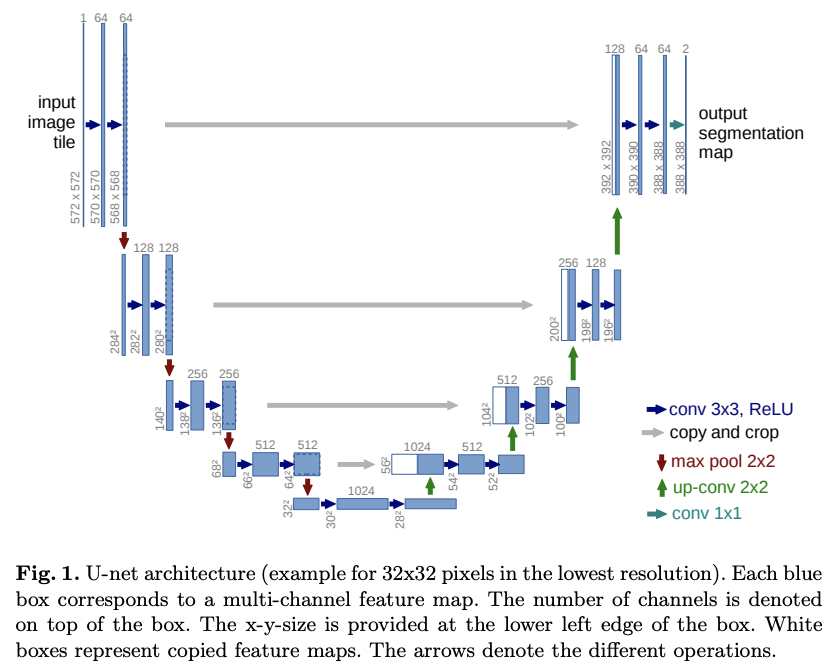

In [8]:
def new_model():
  dropout_rate = 0.5
  input_size = (IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)

  initializer = 'he_normal'   #variance scaling initialization


  # -- Encoder -- #
  # Block encoder 1
  inputs = Input(shape=input_size)
  conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
  conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)


  # Block encoder 2
  max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
  conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
  conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)

  # Block  encoder 3
  max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
  conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
  conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_3)

  # Block  encoder 4
  max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
  conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
  conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)
 
  # -- Encoder -- #
  
  maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
  conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
  conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
  
  # -- Decoder -- #
  # Block decoder 1
  up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))

  merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
  conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
  conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)

  # Block decoder 2
  up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
  merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
  conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
  conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)

  # Block decoder 3
  up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
  merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
  conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
  conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)

  # Block decoder 4
  up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
  merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
  conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
  conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
  conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
  # -- Dencoder -- #

  output = Conv2D(N_CLASSES, 1, activation = 'softmax')(conv_dec_4)

  model = tf.keras.Model(inputs = inputs, outputs = output)
  adm = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name="Adam")
  model.compile(optimizer=adm, loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

  return model

model = new_model()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 80, 112, 64)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

#### Sanity Check to visualize a sample prediction

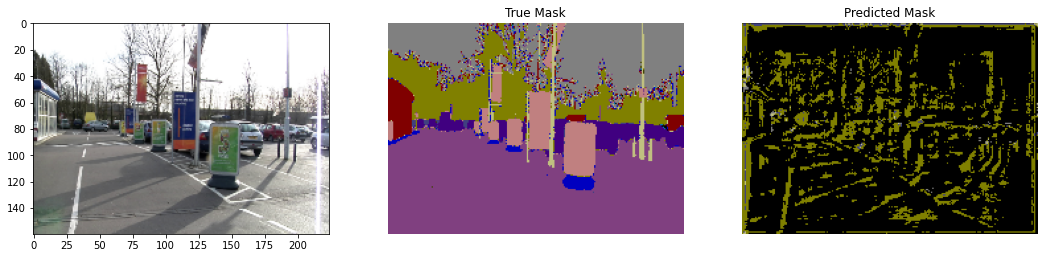

In [9]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    #pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    #We are getting 1 prediction for each class but we want the highest score only, argmax is used
    pred_mask = tf.argmax(pred_mask, axis=-1)

    # pred_mask becomes [IMG_SIZE, IMG_SIZE] reshaped to matplotlib compatible form [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        #The model is expecting a tensor of the size [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3] but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        
        #We add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3] for 1 inference to be faster
        one_img_batch = sample_image[0][tf.newaxis, ...]

        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)

        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0], pred_mask[0]])

for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image, mask

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

show_predictions()

Training for 10 epochs

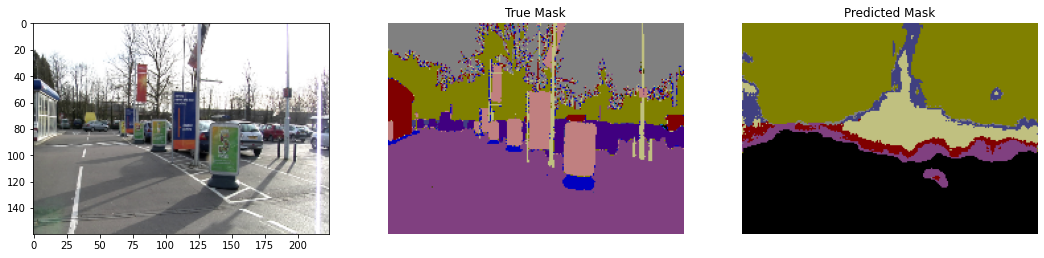


Sample Prediction after epoch 10

45/45 [==============================] - 9s 210ms/step - loss: 1.7373 - accuracy: 0.0984 - val_loss: 1.6116 - val_accuracy: 0.1850


In [10]:
EPOCHS = 10

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS,validation_data=test_dataset,verbose=1,callbacks=[DisplayCallback()])

# Loss Function
- As we know, generally cross entropy loss is not used for training segmentation networks. [This paper](https://arxiv.org/pdf/1707.03237.pdf) proposes a variant of Dice Loss, Generalized Dice Loss (GDL). [This](https://gitmemory.com/issue/keras-team/keras/9395/464445431) can help you to get started with implemetation of GDL. 
- Implement the GDL and train using it as a loss function.
- Use combination of Dice and cross entropy loss.


In [11]:
from keras import backend as K
from keras.utils.np_utils import to_categorical

def dice_coef_12cat(y_true, y_pred):
    '''
    Dice coefficient for 10 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.reshape(K.one_hot(K.cast(y_true, 'int32'), num_classes=12),shape=K.shape(y_pred))
    y_pred_f = y_pred
    w = K.sum(y_true_f,(0,1,2))
    w = 1/(w**2+0.0000001)
    
    numerator = w*K.sum(y_true_f*y_pred_f,(0,1,2))
    numerator = K.sum(numerator)
    denom = w*K.sum(y_true_f+y_pred_f,(0,1,2))
    denom = K.sum(denom)

    GDL = 1-2*numerator/denom
    w = w/K.sum(w)
    w = K.exp(w/5)
    w = w/K.sum(w)*12
    entropy = -w*K.sum(y_true_f*K.log(y_pred_f+0.00000001),(0,1,2))
    entropy = K.sum(entropy)/160/224/8
    return GDL + 0.8*entropy

Training for 50 epochs with GDL

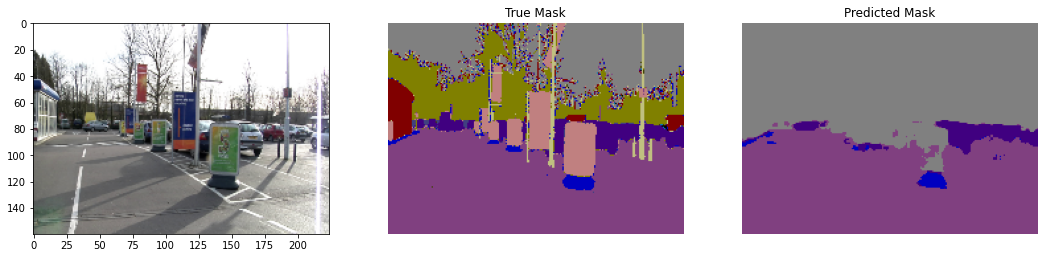


Sample Prediction after epoch 50

45/45 [==============================] - 10s 214ms/step - loss: 2.0720 - accuracy: 0.5579 - val_loss: 2.1650 - val_accuracy: 0.4619


In [12]:
EPOCHS = 50

model = new_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss = dice_coef_12cat,metrics=['accuracy'])


STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS,validation_data=test_dataset,verbose=1,callbacks=[DisplayCallback()])

#Transfer learning
- Implement ResNet-UNet model. You can take help from this post [MobileNet UNet](https://www.tensorflow.org/tutorials/images/segmentation).

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

In [14]:
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow as tf

IMG_HEIGHT = 160     
IMG_WIDTH = 224

base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False)
layer_names = [
    'block_1_expand_relu',   # 80x112
    'block_3_expand_relu',   # 40x56
    'block_6_expand_relu',   # 20x28
    'block_13_expand_relu',  # 10x14
    'block_16_project',      # 5x7
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False


up_stack = [
    pix2pix.upsample(512, 3),  # 5x7 -> 10x14
    pix2pix.upsample(256, 3),  # 10x14 -> 20x28
    pix2pix.upsample(128, 3),  # 20x28 -> 40x56
    pix2pix.upsample(64, 3),   # 40x56 -> 80x112
]

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #80x112 -> 160x224

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

9412608/9406464 [==============================] - 0s 0us/step


Compiling the model on the data in 12 classes

In [15]:
model = unet_model(N_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training for 50 epochs

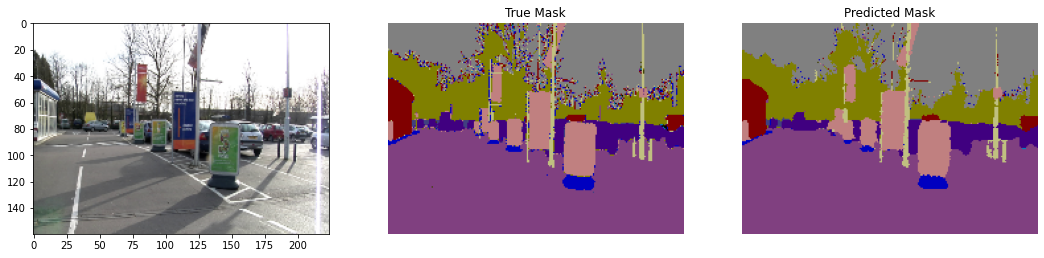


Sample Prediction after epoch 50

45/45 [==============================] - 3s 58ms/step - loss: 0.1582 - accuracy: 0.9388 - val_loss: 0.5549 - val_accuracy: 0.8589


In [16]:
EPOCHS = 50



STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

model2_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

# Model Evaluation

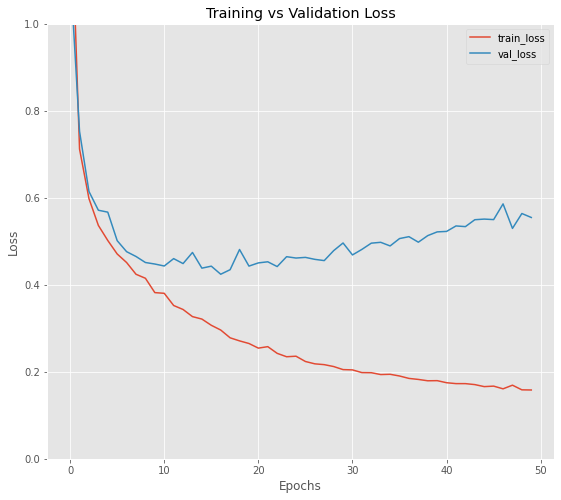

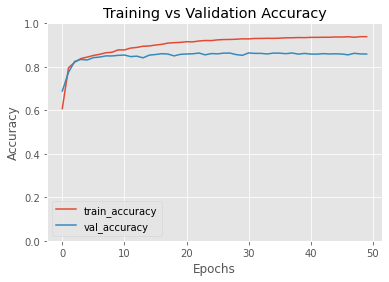

In [19]:
#Get actual number of epochs model was trained for
N = len(model2_history.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training vs Validation Loss")
plt.plot(np.arange(0, N), model2_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), model2_history.history["val_loss"], label="val_loss")
plt.ylim(0, 1)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

fig.add_subplot(1,2,2)
plt.title("Training vs Validation Accuracy")
plt.plot(np.arange(0, N), model2_history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), model2_history.history["val_accuracy"], label="val_accuracy")
plt.ylim(0, 1)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

